In [1]:
import sys
print(sys.path)
sys.path.append('/lib/python3.7/site-packages')
from PIL import Image

['/home/CW01/uia94835/github_home/fv3/nbs/dl2', '/home/CW01/uia94835/miniconda3/lib/python37.zip', '/home/CW01/uia94835/miniconda3/lib/python3.7', '/home/CW01/uia94835/miniconda3/lib/python3.7/lib-dynload', '', '/home/CW01/uia94835/miniconda3/lib/python3.7/site-packages', '/home/CW01/uia94835/miniconda3/lib/python3.7/site-packages/IPython/extensions', '/home/CW01/uia94835/.ipython']


In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
DEBUG_MODE = False

In [4]:
#export
from exp.nb_06 import *

In [5]:
gc.collect()

22

In [6]:
torch.cuda.empty_cache()

## ConvNet

In [85]:
get_data

<function exp.nb_03.get_data()>

In [79]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,2
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [80]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [81]:
import fastai

In [82]:
a = get_dls(train_ds, valid_ds, bs)
a

(<torch.utils.data.dataloader.DataLoader at 0x7f5bad24cdd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5bad24c790>)

In [83]:
data_f = fastai.basic_data.DataBunch(*get_dls(train_ds, valid_ds, bs))

In [84]:
data_f.one_batch()

(tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]]),
 tensor([2, 4]))

In [9]:
nfs = [8,16,32,64,64]

In [10]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
%time run.fit(2, learn)

### Pets

In [112]:
import fastai as f
import fastai.vision as fv

ImportError: cannot import name 'PILLOW_VERSION' from 'PIL' (/home/CW01/uia94835/miniconda3/lib/python3.7/site-packages/PIL/__init__.py)

In [ ]:
f.basic_data.Image

In [110]:

Config.data_path()
untar_path = untar_data(URLs.PETS)
img_path = untar_path/'images'
label_path = untar_path/'annotations'
np.random.seed(2)
pattern = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(img_path, img_fnames, pattern, ds_tfms = get_transforms(), size=size, bs=64)
if normalize: data = data.normalize(imagenet_stats)
data

ImportError: cannot import name 'PILLOW_VERSION' from 'PIL' (/home/CW01/uia94835/miniconda3/lib/python3.7/site-packages/PIL/__init__.py)

## Batchnorm

### Custom

In [86]:
class BatchNorm_my(nn.Module):
    def __init__(self, nf, invmom=0.1, eps = 1e-5):
        super().__init__()
        self.nf = nf
        self.eps = eps
        self.invmom = invmom       
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
    
    def update_stats(self, xb):
        m = xb.mean((0,2,3), keepdim=True)
        v = xb.var((0,2,3), keepdim=True)
        self.means.lerp_(m, self.invmom)
        self.vars.lerp_(v, self.invmom)
        return m,v
    
    def forward(self, xb):
        if DEBUG_MODE: print(xb.shape)
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(xb)
#         else:
        m, v = self.means, self.vars
        normed = (xb - m) / (v + self.eps).sqrt()
        out = self.mults * normed + self.adds
        if DEBUG_MODE: print(m, v.sqrt(), (v+self.eps).sqrt())
        return out

In [102]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if DEBUG_MODE: print('xb.shape = ', xb.shape)
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        #if DEBUG_MODE: print(m, v.sqrt(), (v+self.eps).sqrt())
        return x*self.mults + self.adds

In [48]:
class RunningBatchNorm_my(nn.Module):
    def __init__(self, nf, eps = 1e-5):
        super().__init__()
        self.nf = nf
        self.eps = eps   
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('sums',  torch.zeros(1,nf,1,1))
        self.register_buffer('squares', torch.zeros(1,nf,1,1))
        self.register_buffer('n', torch.zeros(1))
    
    def update_stats(self, xb):
        s = xb.sum((0,2,3), keepdim=True)
        self.sums.add_(s)
        self.squares.add_((xb * xb).sum((0, 2, 3), keepdim=True))
        self.n.add_(xb.shape[0])
        return self.get_stats()
    
    def get_stats(self):
        m = self.sums / self.n
        v = self.squares / self.n - m*m
        return m,v
    
    def forward(self, xb):
        if DEBUG_MODE: print(self.training)
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(xb)
        else:
            m, v = self.get_stats()
#         if DEBUG_MODE: print(m.shape, v.shape)
        normed = (xb - m) / (v + self.eps).sqrt()
        out = self.mults * normed + self.adds
        if DEBUG_MODE: print(m, v.sqrt(), (v+self.eps).sqrt())
        return out

    #todo: add efficient running mean calcuoation
    #https://dev.to/cipharius/calculating-mean-iteratively-3aah
    #https://math.stackexchange.com/questions/106700/incremental-averageing

In [49]:
class RunningBatchNorm_my_stable(nn.Module):
    def __init__(self, nf, eps = 1e-5):
        super().__init__()
        self.nf = nf
        self.eps = eps   
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('squares', torch.zeros(1,nf,1,1))
        self.register_buffer('n', torch.zeros(1))
        self.register_buffer('mean',  torch.zeros(1,nf,1,1))
        
    def update_stats(self, xb):
        s_new = xb.sum((0,2,3), keepdim=True)
        n_delta = xb.shape[0]
        self.mean = self.mean + (s_new - self.mean) / (self.n + n_delta)
        self.squares.add_((xb * xb).sum((0, 2, 3), keepdim=True))
        self.n.add_(n_delta)
        return self.get_stats()
    
    def get_stats(self):
        m = self.mean
        v = self.squares / self.n - m*m
        return m,v
    
    def forward(self, xb):
        if DEBUG_MODE: print(self.training)
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(xb)
        else:
            m, v = self.get_stats()
#         if DEBUG_MODE: print(m.shape, v.shape)
        normed = (xb - m) / (v + self.eps).sqrt()
        out = self.mults * normed + self.adds
        if DEBUG_MODE: print(m, v.sqrt(), (v+self.eps).sqrt())
        return out

    #todo: add efficient running mean calcuoation
    #https://dev.to/cipharius/calculating-mean-iteratively-3aah
    #https://math.stackexchange.com/questions/106700/incremental-averageing

In [40]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [15]:
def getmodel_bn(BN):
    model = nn.Sequential(
        nn.Conv2d(1, 8, 5, bias=False),
        nn.ReLU(),
        BN(8),
        nn.Conv2d(8, 16, 3, bias=False),
        nn.ReLU(),
        BN(16),
        nn.Conv2d(16, 32, 3, bias=False),
        nn.ReLU(),
        BN(32),
        nn.Conv2d(32, 32, 3, bias=False),
        nn.ReLU(),
        BN(32),
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten), 
        nn.Linear(32, data.c)
    )
    return model

In [103]:
model_bn = getmodel_bn(BatchNorm)

In [42]:
model_rbn = getmodel_bn(RunningBatchNorm)

In [50]:
model_bn_my = getmodel_bn(BatchNorm_my)
model_rbn_my = getmodel_bn(RunningBatchNorm_my)
model_rbn_mys = getmodel_bn(RunningBatchNorm_my_stable)

In [44]:
model_nobn = nn.Sequential(
    nn.Conv2d(1, 8, 5),
    nn.ReLU(),
    nn.Conv2d(8, 16, 3),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(flatten), 
    nn.Linear(32, data.c)
)

In [51]:
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
#     model = get_cnn_model(data, nfs, layer, **kwargs)
#     init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

def get_learn_run(model, data, lr, cbs=None, opt_func=None, **kwargs):
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

### Test - No BN

In [20]:
learn,run = get_learn_run(model_nobn, data, lr=0.4, cbs=cbfs)

train: [2.39565125, tensor(0.1000, device='cuda:0')]
valid: [2.3643431640625, tensor(0.1009, device='cuda:0')]


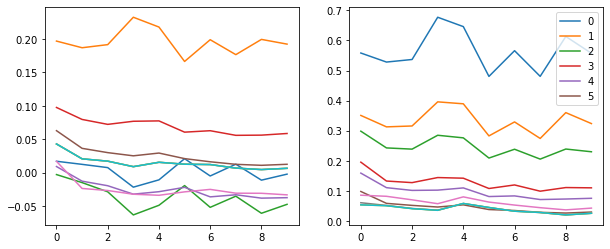

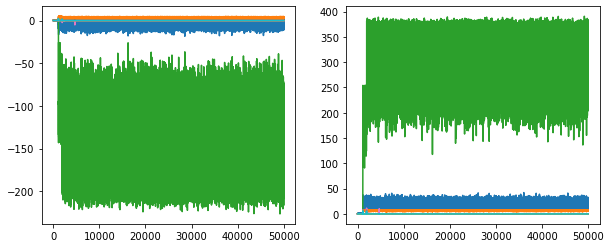

In [21]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

### Test - Fastai BN

In [104]:
learn,run = get_learn_run(model_bn, data, lr=0.4, cbs=cbfs)

In [106]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =  torch.Size([2, 784])
xb.shape =

KeyboardInterrupt: 

### Test - My BN

In [27]:
learn,run = get_learn_run(model_bn_my, data, lr=0.4, cbs=cbfs)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


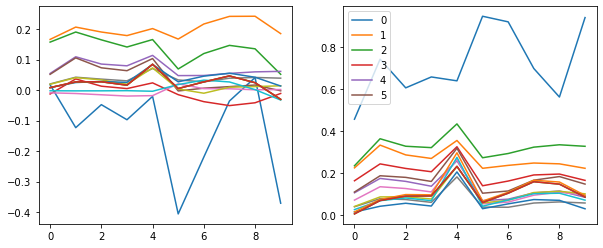

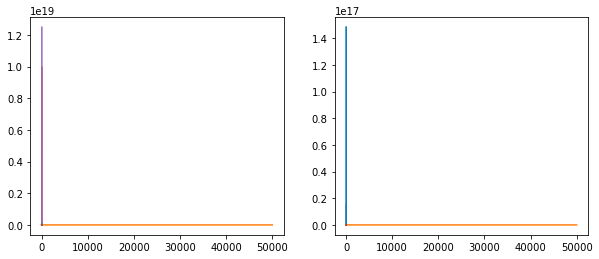

In [28]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

### Test - Fatasi RBN

In [46]:
learn,run = get_learn_run(model_rbn, data, lr=0.4, cbs=cbfs)

train: [392.5946, tensor(0.4641, device='cuda:0')]
valid: [4462.7992, tensor(0.4476, device='cuda:0')]


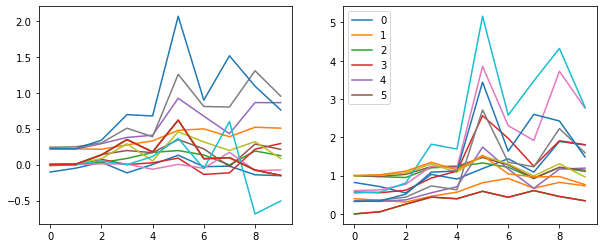

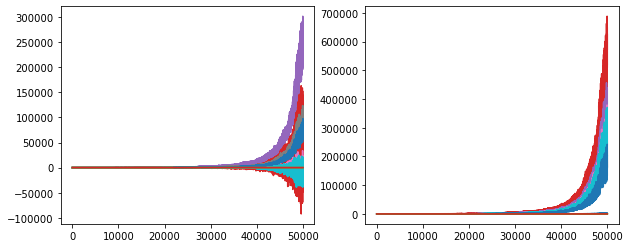

In [47]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

### Test - My RBN

In [52]:
learn,run = get_learn_run(model_rbn_my, data, lr=0.4, cbs=cbfs)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


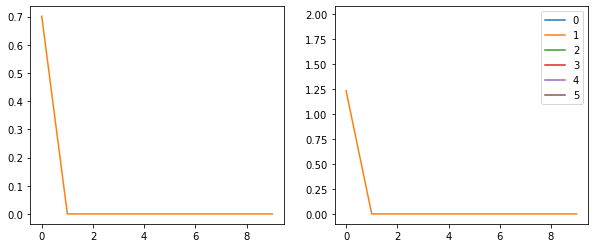

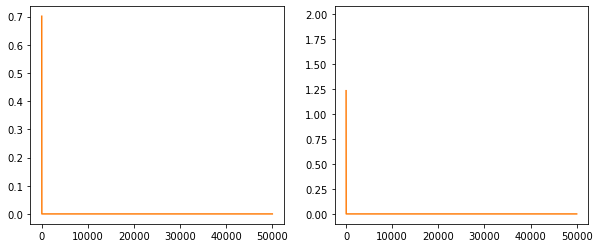

In [53]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

### Test - My RBN stable

In [54]:
learn,run = get_learn_run(model_rbn_mys, data, lr=0.4, cbs=cbfs)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


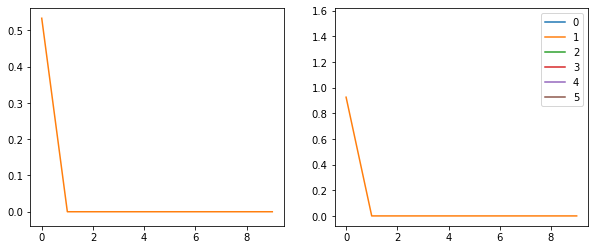

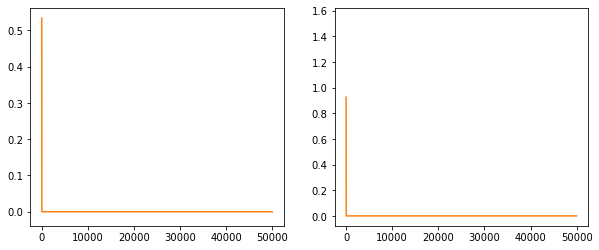

In [55]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

### Unit test 

In [90]:
DEBUG_MODE = True

In [91]:
bn = BatchNorm_my(784)

In [92]:
xb, yb = data_f.one_batch()
print(xb.shape, yb.shape)

torch.Size([2, 784]) torch.Size([2])


In [93]:
bn.forward(xb)

torch.Size([2, 784])


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)